In [ ]:
'''The model was implemented in google colab. And the dataset used for training and testing the model was in google drive hence importing the content of google drive'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import librosa
import pickle

## Audio loading and preprocessing

The shape of log mel spectrogram is: (128, 130)


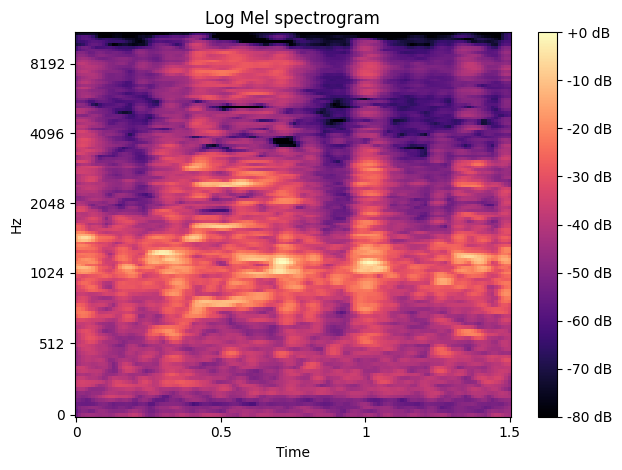

[[-53.26542  -47.905624 -45.073563 ... -41.032967 -43.03602  -44.0667  ]
 [-55.87062  -51.24147  -49.223316 ... -46.633293 -45.146004 -44.846054]
 [-53.497284 -50.095634 -48.63174  ... -49.15653  -46.952553 -45.822388]
 ...
 [-65.34764  -61.493618 -59.01865  ... -70.84958  -65.60329  -63.683693]
 [-65.7716   -61.636642 -59.32206  ... -70.72281  -65.33914  -63.4234  ]
 [-75.49428  -73.85485  -73.7843   ... -71.7928   -66.36156  -64.42255 ]] (128, 130)


In [ ]:
sample_rate = 22050
n_fft = 2048
hop_length = 256
window_type = 'hann'
mel_bins = 128 # Number of mel bands
wav_size = 33075  # (1.5 * 22050)


def audio_to_log_mel_spec(filename):

  '''loading the audio in the form of numpy array at given sample rate'''
  wav, sr = librosa.load(filename, sr=sample_rate)
  # print(wav.shape)

  '''normalizing audio (scaling to range -1 to 1)'''
  wav = librosa.util.normalize(wav)

  '''croping or zero-padding the audio numpy array based on its length'''
  if len(wav) > wav_size:
    wav = wav[:wav_size]
  else:
    '''If audio is shorter than the desired length, zero-pad it'''
    '''pad_length = sample_rate - len(audio)'''
    wav = librosa.util.pad_center(data=wav, size=wav_size)


  '''converting to mel and then log mel spectrogram'''
  mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels = mel_bins, power=2.0)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


  '''for printing the spectrogram'''

  # print("The shape of log mel spectrogram is:", mel_spectrogram_db.shape)
  # librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel',hop_length=hop_length)
  # plt.colorbar(format='%+2.0f dB')
  # plt.title('Log Mel spectrogram')
  # plt.tight_layout()
  # plt.show()

  '''returning log mel spectrogram as 2d numpy array'''
  return mel_spectrogram_db



'''example of using 'audio_to_log_mel_spec' funciton'''
# spec = audio_to_log_mel_spec("/content/drive/MyDrive/Chicken_Dataset/egg/egg_-09.wav")
# print(spec, spec.shape)
# spec = audio_to_log_mel_spec('10_sec_sample.wav')
# print(spec, spec.shape)

## Loading and Labeling the dataset

In [ ]:
'''listing files from storage path(drive)'''

'''caution: file paths may be different on seperate machines'''

alarm = tf.data.Dataset.list_files('/content/drive/MyDrive/Chicken_Dataset/alarm/*.wav')
print('alarm:', len(alarm))

egg = tf.data.Dataset.list_files('/content/drive/MyDrive/Chicken_Dataset/egg/*.wav')
print('egg:', len(egg))

feeding = tf.data.Dataset.list_files('/content/drive/MyDrive/Chicken_Dataset/feeding/*.wav')
print('feeding:', len(feeding))

heat = tf.data.Dataset.list_files('/content/drive/MyDrive/Chicken_Dataset/heat/*.wav')
print('heat:', len(heat))

'''dataset of normal voice of chickens was not avaliable'''
# normal = tf.data.Dataset.list_files('/content/drive/MyDrive/Chicken_Dataset/normal/*.wav')
# print('normal:', len(normal))


'''creating a tensor having audio file path and its label (i.e. labeling the audio file)'''

alarm = tf.data.Dataset.zip((alarm, tf.data.Dataset.from_tensor_slices(tf.constant(0, shape=(len(alarm))))))
egg = tf.data.Dataset.zip((egg, tf.data.Dataset.from_tensor_slices(tf.constant(1, shape=(len(egg))))))
feeding = tf.data.Dataset.zip((feeding, tf.data.Dataset.from_tensor_slices(tf.constant(2, shape=(len(feeding))))))
heat = tf.data.Dataset.zip((heat, tf.data.Dataset.from_tensor_slices(tf.constant(3, shape=(len(heat))))))
# normal = tf.data.Dataset.zip((normal, tf.data.Dataset.from_tensor_slices(tf.constant(4, shape=(len(normal))))))


alarm: 722
egg: 336
feeding: 415
heat: 629



## Splitting (80:20 ratio)

In [ ]:
'''Shuffle'''
alarm = alarm.shuffle(buffer_size=len(alarm))
egg = egg.shuffle(buffer_size=len(egg))
feeding = feeding.shuffle(buffer_size=len(feeding))
heat = heat.shuffle(buffer_size=len(heat))

train_size_0 = int(0.8 * len(alarm))
train_size_1 = int(0.8 * len(egg))
train_size_2 = int(0.8 * len(feeding))
train_size_3 = int(0.8 * len(heat))
# train_size_4 = int(0.8 * len(normal))


train_dataset_0 = alarm.take(train_size_0)
train_dataset_1 = egg.take(train_size_1)
train_dataset_2 = feeding.take(train_size_2)
train_dataset_3 = heat.take(train_size_3)
# train_dataset_4 = heat.take(train_size_4)


test_dataset_0 = alarm.skip(train_size_0)
test_dataset_1 = egg.skip(train_size_1)
test_dataset_2 = feeding.skip(train_size_2)
test_dataset_3 = heat.skip(train_size_3)
# test_dataset_4 = heat.skip(train_size_4)


'''printing the number of samples in each set'''

print("Training (alarm):", len(list(train_dataset_0)))
print("Testing (alarm):", len(list(test_dataset_0)))
print("Training (egg):", len(list(train_dataset_1)))
print("Testing (egg):", len(list(test_dataset_1)))
print("Training (feeding):", len(list(train_dataset_2)))
print("Testing (feeding):", len(list(test_dataset_2)))
print("Training (heat):", len(list(train_dataset_3)))
print("Testing (heat):", len(list(test_dataset_3)))
# print("Training (normal):", len(list(train_dataset_4)))
# print("Testing (normal):", len(list(test_dataset_4)))

Training (alarm): 577
Testing (alarm): 145
Training (egg): 268
Testing (egg): 68
Training (feeding): 332
Testing (feeding): 83
Training (heat): 503
Testing (heat): 126


In [ ]:
'''concatinating all training data sets of different types and similarly for test data sets'''

training_data = train_dataset_0.concatenate(train_dataset_1).concatenate(train_dataset_2).concatenate(train_dataset_3)
test_data = test_dataset_0.concatenate(test_dataset_1).concatenate(test_dataset_2).concatenate(test_dataset_3)

print(len(training_data))
print(len(test_data))


1680
422


In [ ]:
'''shuffling datasets so that model dont gets similar types of sounds together'''

training_data = training_data.shuffle(len(training_data))
test_data = test_data.shuffle(len(test_data))

In [ ]:
'''checking the format of dataset (when the dataset is in tensorflow dataset variable)'''

training_data.as_numpy_iterator().next()

(b'/content/drive/MyDrive/Chicken_Dataset/alarm/174alarm.wav', 0)

## Data preprocessing pipeline

In [ ]:
processed_training_data = []
processed_test_data = []

'''tqdm is used to provide the progress bar so that estimated time of completion can be known'''
for audio_file, label in tqdm(test_data):
  # print(audio_file.numpy())   '''for printing the file name, used to know the name of file, if 'for loop' is getting interrupted because of some corrupt file'''
  log_mel_spectrogram = audio_to_log_mel_spec(audio_file.numpy())
  processed_test_data.append([log_mel_spectrogram, label.numpy()])

for audio_file, label in tqdm(training_data):
  # print(audio_file.numpy())
  log_mel_spectrogram = audio_to_log_mel_spec(audio_file.numpy())
  processed_training_data.append([log_mel_spectrogram, label.numpy()])

In [ ]:
'''checking the prcessed data format'''

# processed_test_data

## Storing processed data for model_training

In [ ]:
'''storing the processed dataset in pickle format'''

with open("/content/drive/MyDrive/training_dataset.pickle", 'wb') as file:
  pickle.dump(processed_training_data, file)

with open("/content/drive/MyDrive/test_dataset.pickle", 'wb') as file:
  pickle.dump(processed_test_data, file)

last saved 12/07/2023, with alarm(722), egg(336), feeding(415), heat(629) sounds

In [ ]:
'''if dataset is not changed, we can skip the data preprocessing part and load the processed data from pickle files'''

with open("/content/drive/MyDrive/training_dataset.pickle", 'rb') as file:
  processed_training_data = pickle.load(file)

with open("/content/drive/MyDrive/test_dataset.pickle", 'rb') as file:
  processed_test_data = pickle.load(file)

In [ ]:
'''Splitting the spectrogram and label from processed dataset and converting their data type from list to np.ndarray'''


'''x_train and x_test contain spectrogram values
   y_train and y_test contain labels'''

x_train = np.array([row[0] for row in processed_training_data])
y_train = np.array([row[1] for row in processed_training_data])
x_test = np.array([row[0] for row in processed_test_data])
y_test = np.array([row[1] for row in processed_test_data])

In [ ]:
'''adding a new axis because CNN layers take 4d inputs
   and [..,..,..,1] here 1 represents that our image is having only one color channel.'''

x_train = x_train[:, :, :, np.newaxis]
print(x_train.shape)

x_test = x_test[:, :, :, np.newaxis]
print(x_test.shape)

(1680, 128, 130, 1)
(422, 128, 130, 1)


In [ ]:
'''y_test data is needed in original format for confusion matrix'''
y_test_orig = y_test

In [ ]:
'''one hot encoding for labels'''

enc_arr = np.zeros((y_train.size, y_train.max() + 1))  '''create a np zerro array of shape = (len of dataset, number of classifications(or labels))'''
enc_arr[np.arange(y_train.size), y_train] = 1   '''making the array value in the row = 1 at the position equal to the numaric value of label'''

y_train = enc_arr

'''initiallising enc_arr to zero values again for test labels'''
enc_arr = np.zeros((y_test.size, y_test.max() + 1))
enc_arr[np.arange(y_test.size), y_test] = 1

y_test = enc_arr

Now input and target dataset is completely processed and is in correct format

## CNN MODEL

In [ ]:
input_shape = (128, 130, 1)

### INCEPTION V3 MODEL

In [ ]:
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights=None,
    input_shape=input_shape,
    pooling='max',
    classifier_activation="softmax",
)

inception_model = tf.keras.models.Sequential([
    inception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

inception_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

inception_model.summary()

In [ ]:
inception_model.fit(x_train, y_train, epochs=30, batch_size=64)

In [ ]:
inception_model.evaluate(x_test, y_test)

In [ ]:
# this model is saved with accuracy of 98.33%, save it again only if accuracy is more than that

# inception_model.save('/content/drive/MyDrive/models/12_07_2023/trained_inception_model')

# 12_07_2023 - 98.33% accuracy in training and 93.13% accuracy on test data

In [ ]:
inception_model = tf.keras.models.load_model('/content/drive/MyDrive/models/12_07_2023/trained_inception_model')

In [ ]:
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802208  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 22,327,780
Trainable params: 22,293,348
Non-trainable params: 34,432
_________________________________________________________________


### RESNET 50 MODEL

In [ ]:
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling='max'
)

resnet_model = tf.keras.models.Sequential([
    resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

resnet_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

resnet_model.summary()

In [ ]:
resnet_model.fit(x_train, y_train, epochs = 30, batch_size = 64)

In [ ]:
resnet_model.evaluate(x_test, y_test)

In [ ]:
# this model is saved with accuracy of 96.49%, save it again only if accuracy is more than that

# resnet_model.save('/content/drive/MyDrive/models/12_07_2023/trained_resnet_model')

# 12_07_2023 - 96.49% accuracy in training and 78.91% accuracy on test data

In [ ]:
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/models/12_07_2023/trained_resnet_model')

In [ ]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23581440  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24,107,012
Trainable params: 24,053,892
Non-trainable params: 53,120
_________________________________________________________________


### SELF MADE MODEL

In [ ]:

# Define the CNN model
self_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
self_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
# self_model.summary()


In [ ]:
self_model.fit(x_train, y_train,
          epochs=10, batch_size = 32)

In [ ]:
self_model.evaluate(x_test, y_test)

In [ ]:
# this model is saved with accuracy of 99.52%, save it again only if accuracy is more than that

# self_model.save('/content/drive/MyDrive/models/12_07_2023/trained_self_model')

# 12_07_2023 - 99% accuracy in training and 97% accuracy on test data

In [ ]:
self_model = tf.keras.models.load_model('/content/drive/MyDrive/models/12_07_2023/trained_self_model')

In [ ]:
self_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 59520)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

### Results/evaluation  (confusion matrix and classification report)

In [ ]:
print(self_model.predict(x_test))
print(y_test)

In [ ]:
# vgg16_model = tf.keras.models.load_model('/content/drive/MyDrive/models/t_vgg16_model')

In [ ]:
y_pred_arr_resnet = resnet_model.predict(x_test)
y_pred_resnet = [np.argmax(row) for row in y_pred_arr_resnet]

y_pred_arr_inception = inception_model.predict(x_test)
y_pred_inception = [np.argmax(row) for row in y_pred_arr_inception]

y_pred_arr_self = self_model.predict(x_test)
y_pred_self = [np.argmax(row) for row in y_pred_arr_self]

14/14 [==============================] - 3s 246ms/step


In [ ]:
x_test.shape

In [ ]:
y_pred_arr

Confusion matrix of ResNet model:
Confusion matrix of InceptionV3 model:
Confusion matrix of self made model:


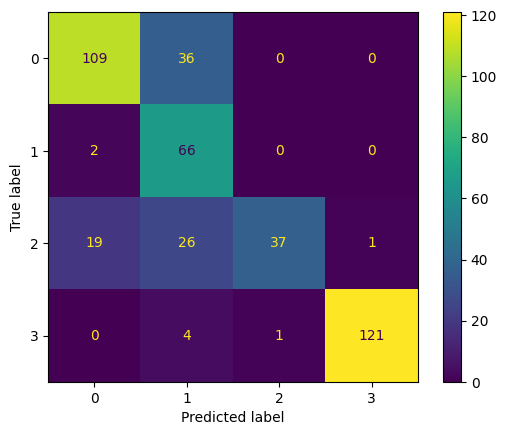

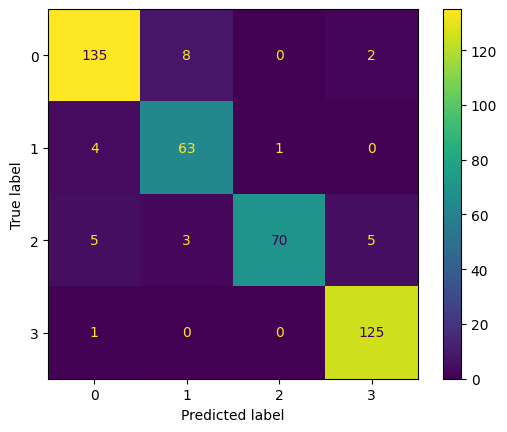

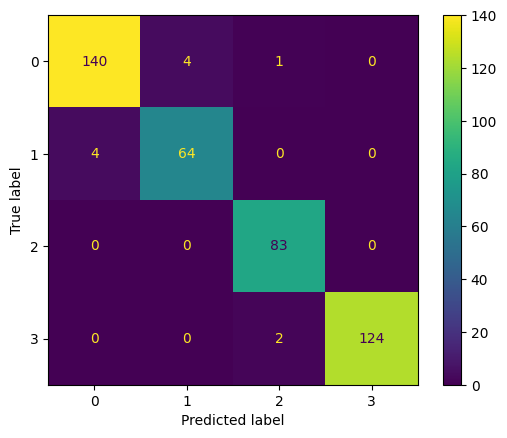

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm_resnet = confusion_matrix(y_test_orig, y_pred_resnet)
cm_inception = confusion_matrix(y_test_orig, y_pred_inception)
cm_self = confusion_matrix(y_test_orig, y_pred_self)

print('Confusion matrix of ResNet model:')
cm_display = ConfusionMatrixDisplay(cm_resnet).plot()

print('Confusion matrix of InceptionV3 model:')
cm_display = ConfusionMatrixDisplay(cm_inception).plot()

print('Confusion matrix of self made model:')
cm_display = ConfusionMatrixDisplay(cm_self).plot()


In [ ]:
from sklearn.metrics import classification_report
target_names = ['alarm', 'egg', 'feeding', 'heat']

print('Classification report of ResNet model: \n',classification_report(y_test_orig, y_pred_resnet, target_names=target_names))
print('Classification report of InceptionV3 model: \n',classification_report(y_test_orig, y_pred_inception, target_names=target_names))
print('Classification report of Self-Made model: \n',classification_report(y_test_orig, y_pred_self, target_names=target_names))


Classification report of ResNet model: 
               precision    recall  f1-score   support

       alarm       0.84      0.75      0.79       145
         egg       0.50      0.97      0.66        68
     feeding       0.97      0.45      0.61        83
        heat       0.99      0.96      0.98       126

    accuracy                           0.79       422
   macro avg       0.83      0.78      0.76       422
weighted avg       0.86      0.79      0.79       422

Classification report of InceptionV3 model: 
               precision    recall  f1-score   support

       alarm       0.93      0.93      0.93       145
         egg       0.85      0.93      0.89        68
     feeding       0.99      0.84      0.91        83
        heat       0.95      0.99      0.97       126

    accuracy                           0.93       422
   macro avg       0.93      0.92      0.92       422
weighted avg       0.93      0.93      0.93       422

Classification report of Self-Made model: 
